<h1> Veštačke neuronske mreže </h1>

Skup podata sadrži rezultate simulacija stabilnosti za referentnu zvezdastu mrežu sa 4 čvora. Sadrži 60.000 zapažanja. Takođe sadrži 12 karakteristika i dve zavisne promenljive.
Cilj je predvideti stabilnost pametne mreže.

Skup podataka nalazi se na linku: <a> https://www.kaggle.com/pcbreviglieri/smart-grid-stability </a>. 




In [1]:
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
import keras.backend as K
from sklearn.decomposition import PCA
from keras import regularizers
from keras.regularizers import l2
from keras.regularizers import l1

<h1> Učitavanje podataka <h1>

In [2]:
dataset=pd.read_csv('smart_grid_stability_augmented.csv')
dataset.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


<h1> Preprocesiranje i deskriptivna statistika podataka </h1>

In [3]:
print('Nedostajuće vrednosti:')
print(dataset.isnull().sum())
print('Broj nedostajućih vrednosti: ', dataset.isnull().sum().sum())

print('\nTipovi podataka')
print(dataset.info())

print('\nSrednja vrednost:')
print(dataset.mean())
 
print('\nMedijana:')
print(dataset.median())

print('\nVarijansa:')
print(dataset.var())

print('\nDuplikati:')
print(dataset.duplicated().sum())

Nedostajuće vrednosti:
tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64
Broj nedostajućih vrednosti:  0

Tipovi podataka
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB
None

S

In [4]:
print('Deskriptivna analiza:')
dataset.describe()

Deskriptivna analiza:


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


In [5]:
dataset.skew()

tau1   -0.000005
tau2   -0.000001
tau3   -0.000001
tau4   -0.000001
p1     -0.012688
p2      0.000003
p3      0.000003
p4      0.000003
g1      0.000003
g2      0.000002
g3      0.000002
g4      0.000002
stab    0.018661
dtype: float64

Kako je sadržaj skupa podataka rezultat simulacije , vrednosti ne nedostaju i nema duplikata.

In [6]:
shape = dataset.shape
print('Velicina dataseta')
print(shape)

Velicina dataseta
(60000, 14)


Text(0.5, 1.0, 'Stability distribution')

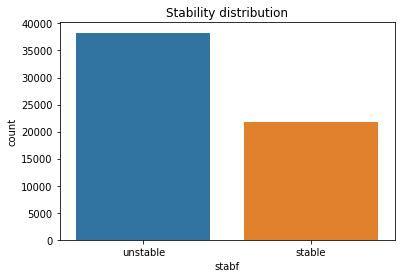

In [7]:
ax = sns.countplot(x='stabf', data=dataset)
plt.title('Stability distribution')

Text(0.5, 1.0, 'Stability distribution')

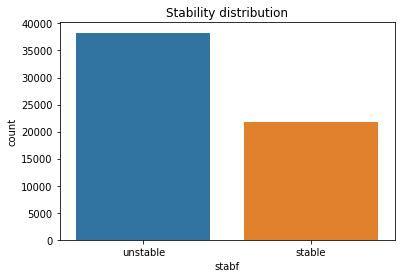

In [8]:
ax = sns.countplot(x='stabf', data=dataset)
plt.title('Stability distribution')

Nakon prevođenja kategoričkog atributa "stabf", vrednost unstable je označena sa 1 , stable sa 0.

In [9]:
le = preprocessing.LabelEncoder()
dataset.stabf = le.fit_transform(dataset.stabf)

Text(0.5, 1.0, 'Correlation Heatmap')

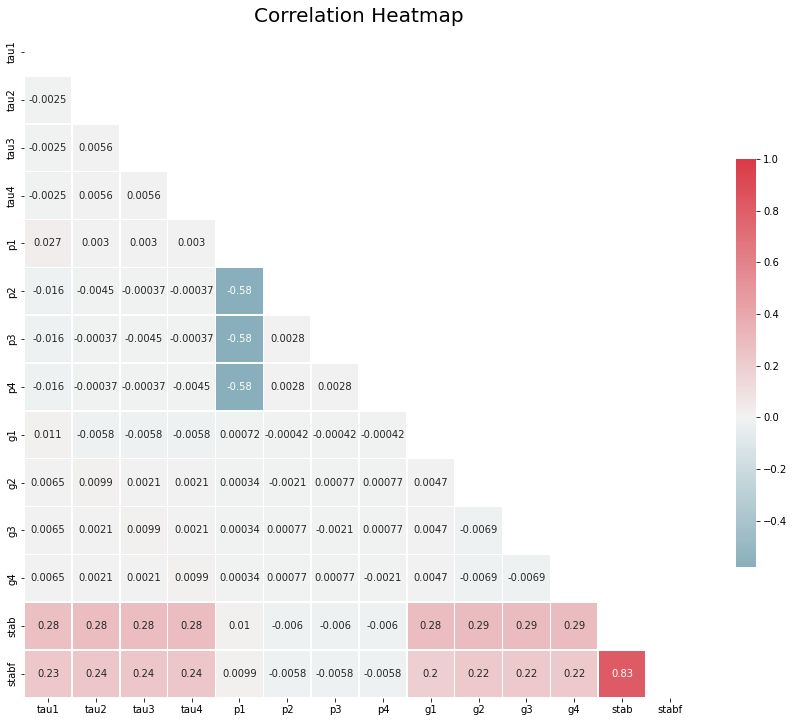

In [10]:
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask,annot=True, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap', fontsize=20)

Kako postoji direktna veza između „stab“ i „stabf“ („stabf“ = „stable“ ako je „stab“ <= 0, u suprotnom „unstable“), „stabf“ će ostati kao jedina zavisna promenljiva

In [11]:
X=dataset.iloc[:, :-2].values
y=dataset.iloc[:, 13].values

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_scaled=scaler.fit_transform(X)

<h1> Kreiranje modela </h1>

Kreiramo mrežu sa tri sloja. Model očekuje redove podataka sa 12 karakteristika ( input_dim = 12)
Prvi skriveni sloj ima 10 čvorova (neurona) i koristi Rectified Linear Unit (ReLU) aktivacionu funkciju.
Drugi skriveni sloj ima 6 čvorova (neurona) i takođe koristi ReLu funkciju aktivacije.
Izlazni sloj ima jedan čvor i koristi sigmoidnu funkciju aktivacije. 
Koristimo sigmoidnu funkciju na izlazu, kako bismo osigurali da je  izlaz između 0 i 1 i da ga je lako mapirati klase sa zadanim pragom od 0,5.
Koristi se binary crossentropy funkcija gubitka. proces učenja odvija se u 50 epoha i 1000 serija. 

In [14]:
classifier = Sequential()
classifier.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' , input_dim = 12))
classifier.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"] )

In [15]:
history=classifier.fit(X_train, y_train, validation_data = (X_test,y_test), batch_size=1000 , epochs=50 )

Epoch 1/50
42/42 [==============================] - 1s 5ms/step - loss: 0.6890 - accuracy: 0.6339 - val_loss: 0.6826 - val_accuracy: 0.6378
Epoch 2/50
42/42 [==============================] - 0s 2ms/step - loss: 0.6668 - accuracy: 0.6381 - val_loss: 0.6418 - val_accuracy: 0.6378
Epoch 3/50
42/42 [==============================] - 0s 2ms/step - loss: 0.6032 - accuracy: 0.6381 - val_loss: 0.5608 - val_accuracy: 0.6378
Epoch 4/50
42/42 [==============================] - 0s 2ms/step - loss: 0.5282 - accuracy: 0.6381 - val_loss: 0.5039 - val_accuracy: 0.6378
Epoch 5/50
42/42 [==============================] - 0s 2ms/step - loss: 0.4907 - accuracy: 0.6381 - val_loss: 0.4831 - val_accuracy: 0.6378
Epoch 6/50
42/42 [==============================] - 0s 2ms/step - loss: 0.4771 - accuracy: 0.6381 - val_loss: 0.4747 - val_accuracy: 0.6378
Epoch 7/50
42/42 [==============================] - 0s 2ms/step - loss: 0.4706 - accuracy: 0.7103 - val_loss: 0.4697 - val_accuracy: 0.8112
Epoch 8/50
42/42 [==

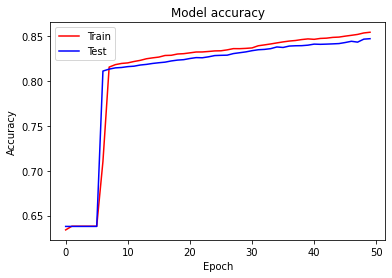

In [16]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

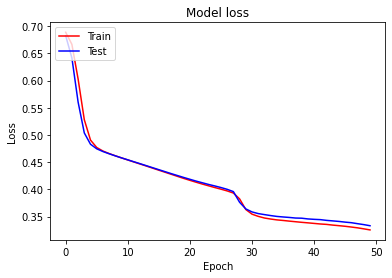

In [17]:
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

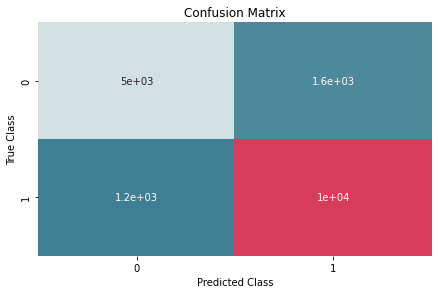

In [18]:
y_pred = classifier.predict(X_test)
y_pred=(y_pred > 0.5)
class_names=[0,1]
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 5, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [19]:
print("\nClassification report:\n")
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))


Classification report:

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      6519
           1       0.87      0.90      0.88     11481

    accuracy                           0.85     18000
   macro avg       0.84      0.83      0.83     18000
weighted avg       0.85      0.85      0.85     18000



<h2> Smanjivanje overfitinga ranim zaustavljanjem (Early Stopping) </h2>

In [20]:
classifier = Sequential()
classifier.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' , input_dim = 12))
classifier.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"] )

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor="val_loss", patience=2)]

In [22]:
history=classifier.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test), batch_size=1000 , epochs=60 )

Epoch 1/60
42/42 [==============================] - 1s 4ms/step - loss: 0.6886 - accuracy: 0.6376 - val_loss: 0.6811 - val_accuracy: 0.6378
Epoch 2/60
42/42 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.6381 - val_loss: 0.6329 - val_accuracy: 0.6378
Epoch 3/60
42/42 [==============================] - 0s 2ms/step - loss: 0.5880 - accuracy: 0.7046 - val_loss: 0.5380 - val_accuracy: 0.7974
Epoch 4/60
42/42 [==============================] - 0s 2ms/step - loss: 0.4951 - accuracy: 0.8090 - val_loss: 0.4594 - val_accuracy: 0.8133
Epoch 5/60
42/42 [==============================] - 0s 2ms/step - loss: 0.4357 - accuracy: 0.8153 - val_loss: 0.4197 - val_accuracy: 0.8126
Epoch 6/60
42/42 [==============================] - 0s 2ms/step - loss: 0.4087 - accuracy: 0.8139 - val_loss: 0.4045 - val_accuracy: 0.8122
Epoch 7/60
42/42 [==============================] - 0s 2ms/step - loss: 0.3983 - accuracy: 0.8148 - val_loss: 0.3981 - val_accuracy: 0.8135
Epoch 8/60
42/42 [==

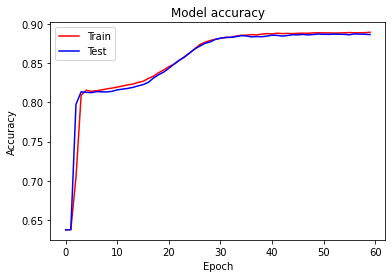

In [23]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

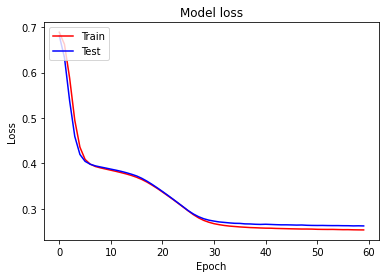

In [24]:
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

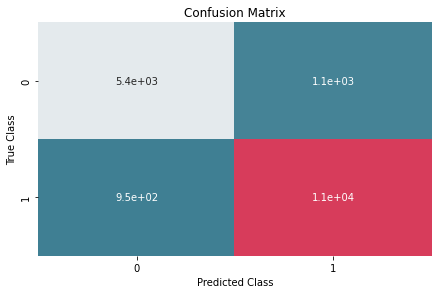

In [25]:
y_pred = classifier.predict(X_test)
y_pred=(y_pred > 0.5)
class_names=[0,1]
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 5, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [26]:
accuracy_Cross = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))


Classification report:

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      6519
           1       0.91      0.92      0.91     11481

    accuracy                           0.89     18000
   macro avg       0.88      0.87      0.88     18000
weighted avg       0.89      0.89      0.89     18000



<h2> Vizuelizacija veštačke neuronske mreže koja se koristi </h2>

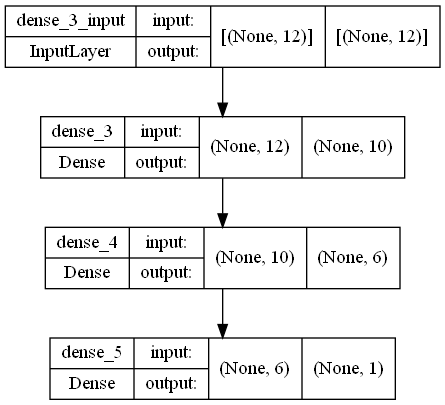

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

SVG(model_to_dot(classifier, show_shapes=True).create(prog="dot", format="svg"))
plot_model(classifier, show_shapes=True, to_file="network.png")

<h2> Podešavanje mreže - odabir najbojih hipermapametara mreže </h2>

Iz prethodnih rezultata se može videti da je odabrana arihitektura mreže (3 sloja sa odgovarajućim brojem neurona) dala dobre rezultate. Zbog toga arhitektura neće biti promenjena, ali je potrebno pretražiti hiperparametre, da bi se što bolje odabrao broj epoha i serija, kao i optimizator.
Koristi se GridSearch za pretragu hiperparametara.

In [28]:
number_of_features=12
def create_network(optimizer="adam"):
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return network

In [29]:
neural_network = KerasClassifier(build_fn=create_network, verbose=0)
epochs = [60,100]
batches = [50,100,1000]
optimizers = ["adam","rmsprop"]
hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)
grid_result = grid.fit(X_scaled, y)

C:\Users\Ilija\AppData\Local\Temp\ipykernel_17444\2796883518.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network = KerasClassifier(build_fn=create_network, verbose=0)


In [31]:
grid_result.best_params_

{'batch_size': 50, 'epochs': 100, 'optimizer': 'rmsprop'}

Nadalje će broj epoha i serija biti 100, i koristiće se adam optimizator. Koristiće se različite funkcije gubitka (loss fje).

<h2> Binary crossentropy </h2>

In [32]:
def create_network_crossentropy():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return network

In [33]:
neural_network = KerasClassifier(build_fn=create_network_crossentropy, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score with crossentropy loss",cross_val_score(neural_network, X_scaled, y, cv=20))

C:\Users\Ilija\AppData\Local\Temp\ipykernel_17444\2207222976.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network = KerasClassifier(build_fn=create_network_crossentropy, epochs=100, batch_size=100, verbose=0)


Cross-validation score with crossentropy loss [0.96033335 0.954      0.95633334 0.96100003 0.95200002 0.95566666
 0.94499999 0.95333332 0.95300001 0.95366669 0.95899999 0.95599997
 0.949      0.95433331 0.96066666 0.9576667  0.95366669 0.94633335
 0.95366669 0.95533335]


In [34]:
history=neural_network.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))

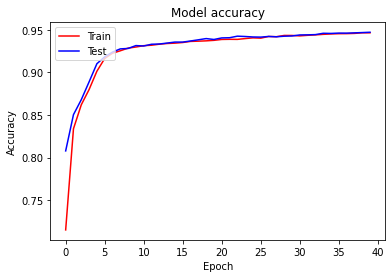

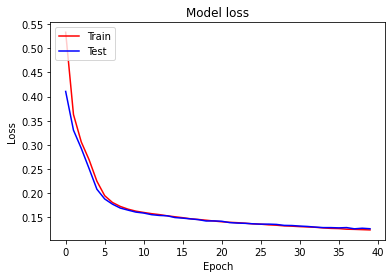

In [36]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      6519
           1       0.95      0.97      0.96     11481

    accuracy                           0.95     18000
   macro avg       0.95      0.94      0.94     18000
weighted avg       0.95      0.95      0.95     18000



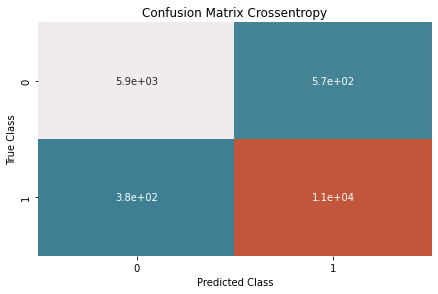

In [37]:
y_pred = neural_network.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_crossentropy = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
target_names = ['0', '1']
class_names=[0,1]
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix Crossentropy"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

<h2> Hinge loss </h2>

In [38]:
def create_network_hinge():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="hinge", optimizer="adam", metrics=["accuracy"])
    return network

In [39]:
neural_network_hinge = KerasClassifier(build_fn=create_network_hinge, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score hinge loss function" ,cross_val_score(neural_network_hinge, X_scaled, y, cv=20))

C:\Users\Ilija\AppData\Local\Temp\ipykernel_17444\1641245915.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network_hinge = KerasClassifier(build_fn=create_network_hinge, epochs=100, batch_size=100, verbose=0)


Cross-validation score hinge loss function [0.92633331 0.87800002 0.935      0.93666667 0.93300003 0.89233333
 0.93766665 0.87199998 0.95099998 0.88766664 0.89633334 0.87300003
 0.94566667 0.85233331 0.94366664 0.95266664 0.92333335 0.89133334
 0.92500001 0.93433332]


In [40]:
history_hinge=neural_network_hinge.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))

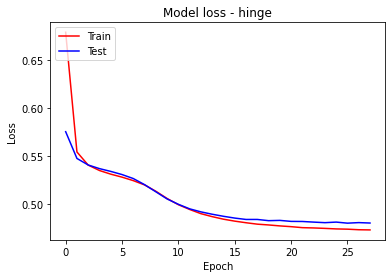

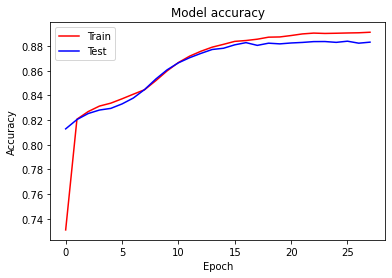

In [41]:
plt.plot(history_hinge.history['loss'],"r-") 
plt.plot(history_hinge.history['val_loss'],"b-") 
plt.title('Model loss - hinge') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()
plt.plot(history_hinge.history['accuracy'], "r-")
plt.plot(history_hinge.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      6519
           1       0.89      0.93      0.91     11481

    accuracy                           0.88     18000
   macro avg       0.88      0.86      0.87     18000
weighted avg       0.88      0.88      0.88     18000



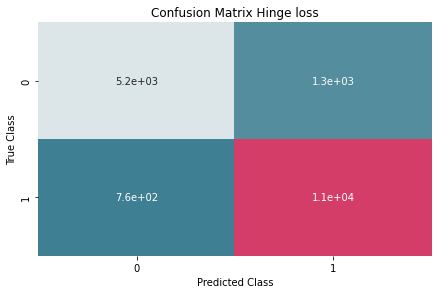

In [42]:
y_pred = neural_network_hinge.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_hinge = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 0, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix Hinge loss"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

<h2> Squared hinge </h2>

In [43]:
def create_network_squared_hinge():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="squared_hinge", optimizer="adam", metrics=["accuracy"])
    return network

In [44]:
neural_network_squared_hinge = KerasClassifier(build_fn=create_network_squared_hinge, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score squared hinge loss function" ,cross_val_score(neural_network_squared_hinge, X_scaled, y, cv=20))

C:\Users\Ilija\AppData\Local\Temp\ipykernel_17444\3111338360.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network_squared_hinge = KerasClassifier(build_fn=create_network_squared_hinge, epochs=100, batch_size=100, verbose=0)


Cross-validation score squared hinge loss function [0.94033331 0.94833332 0.94333333 0.93933332 0.94700003 0.94733334
 0.94266665 0.94666666 0.93166667 0.93333334 0.94466668 0.94533336
 0.94066668 0.93766665 0.93366665 0.93800002 0.90233332 0.93466669
 0.90233332 0.93633336]


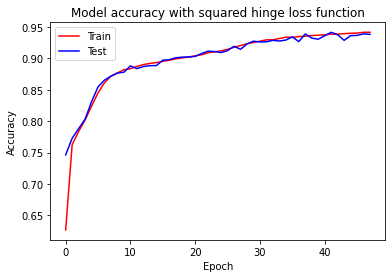

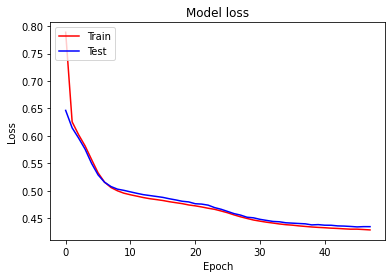

In [45]:
history_squared_hinge=neural_network_squared_hinge.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))
plt.plot(history_squared_hinge.history['accuracy'], "r-")
plt.plot(history_squared_hinge.history['val_accuracy'],  "b-")
plt.title('Model accuracy with squared hinge loss function')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_squared_hinge.history['loss'],"r-") 
plt.plot(history_squared_hinge.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6519
           1       0.98      0.92      0.95     11481

    accuracy                           0.94     18000
   macro avg       0.93      0.95      0.93     18000
weighted avg       0.94      0.94      0.94     18000



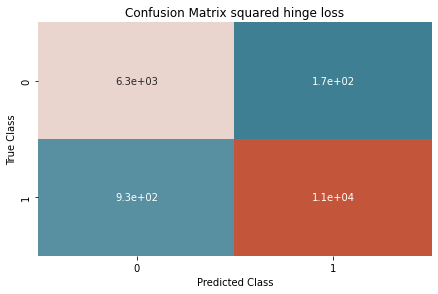

In [46]:
y_pred = neural_network_squared_hinge.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_squared_hinge = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix squared hinge loss"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

<h2> Kullback-Leibler divergence </h2>

In [47]:
def create_network_KL():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="kullback_leibler_divergence", optimizer="adam", metrics=["accuracy"])
    return network 

In [48]:
neural_network_KL = KerasClassifier(build_fn=create_network_KL, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score - Kullback-Leibler divergence loss function" ,cross_val_score(neural_network_KL, X_scaled, y, cv=20))

C:\Users\Ilija\AppData\Local\Temp\ipykernel_17444\1631446142.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network_KL = KerasClassifier(build_fn=create_network_KL, epochs=100, batch_size=100, verbose=0)


Cross-validation score - Kullback-Leibler divergence loss function [0.63366669 0.64399999 0.64099997 0.62900001 0.63999999 0.64200002
 0.63300002 0.63366669 0.64999998 0.63366669 0.63366669 0.64399999
 0.64099997 0.62900001 0.63999999 0.64200002 0.63300002 0.63366669
 0.64999998 0.63366669]


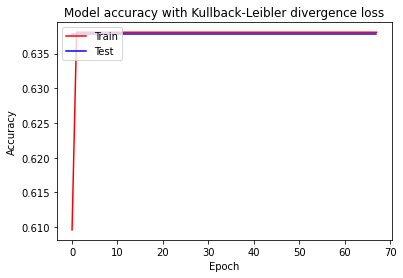

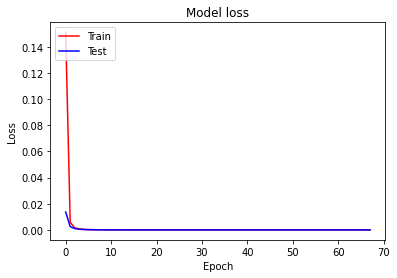

In [49]:
history_KL=neural_network_KL.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))
plt.plot(history_KL.history['accuracy'], "r-")
plt.plot(history_KL.history['val_accuracy'],  "b-")
plt.title('Model accuracy with Kullback-Leibler divergence loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_KL.history['loss'],"r-") 
plt.plot(history_KL.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6519
           1       0.64      1.00      0.78     11481

    accuracy                           0.64     18000
   macro avg       0.32      0.50      0.39     18000
weighted avg       0.41      0.64      0.50     18000



c:\users\ilija\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ilija\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ilija\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

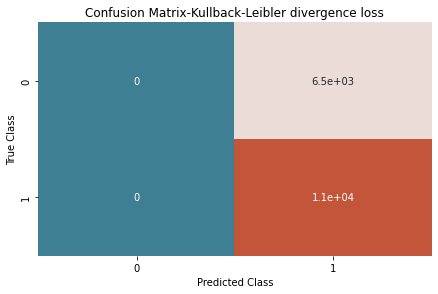

In [50]:
y_pred = neural_network_KL.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_KL = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix-Kullback-Leibler divergence loss"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

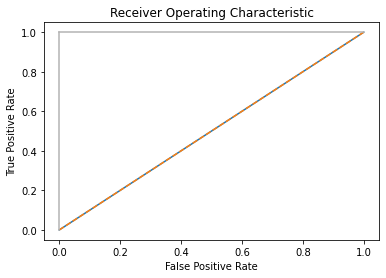

In [51]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,
 y_pred)
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<h2> Dobijene tačnosti sa različitim loss funkcijama </h2>

Text(0.5, 0, 'Loss function')

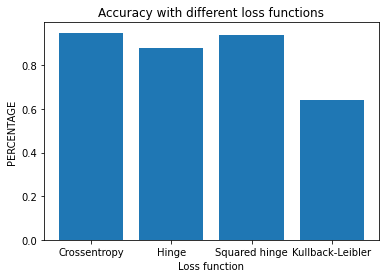

In [52]:
name =[ 'Crossentropy','Hinge', 'Squared hinge','Kullback-Leibler']
accuracy = (round(accuracy_crossentropy, 2),round(accuracy_hinge, 2),round(accuracy_squared_hinge, 2),round(accuracy_KL, 2))
bars=plt.bar(name, accuracy)
plt.title("Accuracy with different loss functions")
plt.ylabel('PERCENTAGE')
plt.xlabel('Loss function')

<h1> Regularizacija </h1>

Regularizacija je postupak za smanjenja overfittinga.

<h2> Dropout regularizacija </h2>

Model proizvoljno odbacuje, ili deaktivira nekoliko neurona oređenog sloja tokom svake iteracije. Prema tome, u svakoj iteraciji model  gleda na malo drugačiju sopstvenu strukturu, kako bi je optimizovala. Osim što smanjuje overfitting, efikana je i zbog smanjenog računanja, što utiče na performanse.

In [53]:
network_dropout = Sequential()
network_dropout.add(layers.Dropout(0.2, input_shape=(number_of_features,)))
network_dropout.add(layers.Dense(units=10, activation="relu"))
network_dropout.add(layers.Dropout(0.5))
network_dropout.add(layers.Dense(units=6, activation="relu"))
network_dropout.add(layers.Dropout(0.5))
network_dropout.add(layers.Dense(units=1, activation="sigmoid"))
network_dropout.compile(loss="squared_hinge", optimizer="adam", metrics=["accuracy"])
history_dropout=network_dropout.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 1s 2ms/step - loss: 0.8961 - accuracy: 0.4416 - val_loss: 0.7479 - val_accuracy: 0.5628
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 0.8086 - accuracy: 0.4892 - val_loss: 0.6700 - val_accuracy: 0.6992
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7704 - accuracy: 0.5185 - val_loss: 0.6501 - val_accuracy: 0.7479
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7509 - accuracy: 0.6626 - val_loss: 0.6434 - val_accuracy: 0.7655
Epoch 5/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7422 - accuracy: 0.7005 - val_loss: 0.6400 - val_accuracy: 0.7749
Epoch 6/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7374 - accuracy: 0.7107 - val_loss: 0.6374 - val_accuracy: 0.7778
Epoch 7/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7324 - accuracy: 0.7184 - val_loss: 0.6335 - val_accuracy: 0.7839

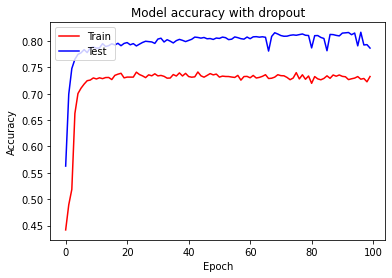

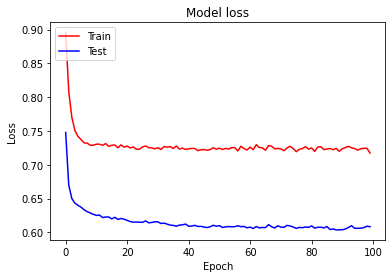

In [54]:
plt.plot(history_dropout.history['accuracy'], "r-")
plt.plot(history_dropout.history['val_accuracy'],  "b-")
plt.title('Model accuracy with dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_dropout.history['loss'],"r-") 
plt.plot(history_dropout.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [55]:
y_pred = network_dropout.predict(X_test)
y_pred=(y_pred > 0.5)
dropout_loss, dropout_acc = network_dropout.evaluate(X_test,  y_test, verbose=2)
print("Loss: ", dropout_loss)
print("Accuracy: ", dropout_acc)

563/563 - 1s - loss: 0.6083 - accuracy: 0.7868 - 668ms/epoch - 1ms/step
Loss:  0.6083314418792725
Accuracy:  0.7867777943611145


<h2> L1 regularizacija </h2>

Proces regularizacije se može prikazati kao
cost funkcija = loss (kako je definisano za model) + hiperparametar × [weights] (težine)
<br>
Na osnovu načina na koji se težine dodaju loss funkciji, postoje L1 i L2 regularizacija.

In [56]:
model = Sequential()
model.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' ,kernel_regularizer=regularizers.l1(0.01), input_dim = 12))
model.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu',kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid',))
model.compile(optimizer = 'adam', loss ='binary_crossentropy' , metrics = ["accuracy"])
history_l1=model.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6679 - accuracy: 0.6377 - val_loss: 0.6550 - val_accuracy: 0.6378
Epoch 2/100
420/420 [==============================] - 1s 1ms/step - loss: 0.6548 - accuracy: 0.6381 - val_loss: 0.6549 - val_accuracy: 0.6378
Epoch 3/100
420/420 [==============================] - 1s 1ms/step - loss: 0.6548 - accuracy: 0.6381 - val_loss: 0.6549 - val_accuracy: 0.6378
Epoch 4/100
420/420 [==============================] - 1s 1ms/step - loss: 0.6547 - accuracy: 0.6381 - val_loss: 0.6550 - val_accuracy: 0.6378
Epoch 5/100
420/420 [==============================] - 1s 1ms/step - loss: 0.6548 - accuracy: 0.6381 - val_loss: 0.6549 - val_accuracy: 0.6378
Epoch 6/100
420/420 [==============================] - 1s 1ms/step - loss: 0.6548 - accuracy: 0.6381 - val_loss: 0.6549 - val_accuracy: 0.6378
Epoch 7/100
420/420 [==============================] - 1s 1ms/step - loss: 0.6548 - accuracy: 0.6381 - val_loss: 0.6549 - val_accuracy: 0.6378

In [57]:
y_pred = model.predict(X_test)
y_pred=(y_pred > 0.5)
l1_loss, l1_acc = model.evaluate(X_test,  y_test, verbose=2)
print("Loss: ", l1_loss)
print("Accuracy: ", l1_acc)

563/563 - 1s - loss: 0.6549 - accuracy: 0.6378 - 729ms/epoch - 1ms/step
Loss:  0.6549169421195984
Accuracy:  0.6378333568572998


<h2> L2 regularizacija </h2>

In [58]:
model = Sequential()
model.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' ,kernel_regularizer=regularizers.l2(0.01), input_dim = 12))
model.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid',))
model.compile(optimizer = 'adam', loss ='binary_crossentropy' , metrics = ["accuracy"])
history_l2=model.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 1s 2ms/step - loss: 0.5944 - accuracy: 0.6534 - val_loss: 0.5174 - val_accuracy: 0.8018
Epoch 2/100
420/420 [==============================] - 1s 1ms/step - loss: 0.4981 - accuracy: 0.8072 - val_loss: 0.4844 - val_accuracy: 0.8074
Epoch 3/100
420/420 [==============================] - 1s 1ms/step - loss: 0.4721 - accuracy: 0.8127 - val_loss: 0.4642 - val_accuracy: 0.8101
Epoch 4/100
420/420 [==============================] - 1s 1ms/step - loss: 0.4553 - accuracy: 0.8141 - val_loss: 0.4519 - val_accuracy: 0.8109
Epoch 5/100
420/420 [==============================] - 1s 1ms/step - loss: 0.4443 - accuracy: 0.8144 - val_loss: 0.4418 - val_accuracy: 0.8125
Epoch 6/100
420/420 [==============================] - 1s 1ms/step - loss: 0.4367 - accuracy: 0.8149 - val_loss: 0.4355 - val_accuracy: 0.8132
Epoch 7/100
420/420 [==============================] - 1s 1ms/step - loss: 0.4308 - accuracy: 0.8155 - val_loss: 0.4306 - val_accuracy: 0.8119

In [59]:
y_pred = model.predict(X_test)
y_pred=(y_pred > 0.5)
l2_loss, l2_acc = model.evaluate(X_test,  y_test, verbose=2)
print("Loss: ", l2_loss)
print("Accuracy: ", l2_acc)

563/563 - 1s - loss: 0.4030 - accuracy: 0.8110 - 665ms/epoch - 1ms/step
Loss:  0.40303462743759155
Accuracy:  0.8109999895095825


<h2> Custom loss funkcija </h2>

Varijanta logaritamske loss funkcije sa negativnim predznakom.
Kada je y_true = 1 (slučaj kada je pametna mreža nestabilna jer je 1=unstable), loss je tipični logaritamski gubitak. 
Kada je y_true = 0 (stablina mreža): ako je predviđeno  0.2, to je dobro (gubitak mali); ako je y_pred 0.5 nije tako loše, ali sto je veće y_pred, veći je gubitak, loše je predviđanje.

In [60]:
def custom_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    loss= -(y_true*K.log(y_pred) - (1-y_true)*K.log(1-y_pred)**2)
    loss = K.sum(loss, axis=1)       
    
    return loss

In [61]:
classifier_cl = Sequential()
classifier_cl.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' , input_dim = 12,dtype='float32'))
classifier_cl.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu'))
classifier_cl.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid'))

In [62]:
classifier_cl.compile(optimizer = 'adam', loss =custom_loss , metrics = ["accuracy"], run_eagerly=True )

In [63]:
history_cl=classifier_cl.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 5s 12ms/step - loss: 0.4771 - accuracy: 0.7831 - val_loss: 0.3928 - val_accuracy: 0.8112
Epoch 2/100
420/420 [==============================] - 5s 12ms/step - loss: 0.3761 - accuracy: 0.8159 - val_loss: 0.3588 - val_accuracy: 0.8261
Epoch 3/100
420/420 [==============================] - 5s 12ms/step - loss: 0.3266 - accuracy: 0.8445 - val_loss: 0.3043 - val_accuracy: 0.8544
Epoch 4/100
420/420 [==============================] - 5s 12ms/step - loss: 0.2853 - accuracy: 0.8678 - val_loss: 0.2721 - val_accuracy: 0.8750
Epoch 5/100
420/420 [==============================] - 5s 11ms/step - loss: 0.2418 - accuracy: 0.8930 - val_loss: 0.2280 - val_accuracy: 0.9012
Epoch 6/100
420/420 [==============================] - 5s 12ms/step - loss: 0.2120 - accuracy: 0.9101 - val_loss: 0.2126 - val_accuracy: 0.9123
Epoch 7/100
420/420 [==============================] - 5s 12ms/step - loss: 0.2021 - accuracy: 0.9124 - val_loss: 0.2070 - val_accuracy:

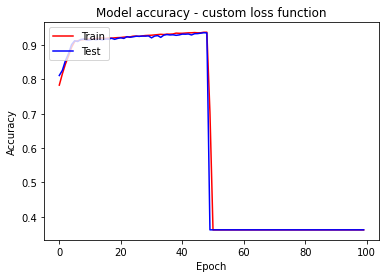

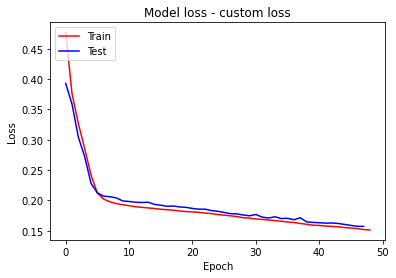

In [64]:
plt.plot(history_cl.history['accuracy'], "r-")
plt.plot(history_cl.history['val_accuracy'],  "b-")
plt.title('Model accuracy - custom loss function')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_cl.history['loss'],"r-") 
plt.plot(history_cl.history['val_loss'],"b-") 
plt.title('Model loss - custom loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

<h1> Redukcija dimenzionalnosti </h1>

<h2> Da li PCA može poboljšati rezultate klasifikacije kod veštačkih neuronskih mreža? </h2>

In [65]:
X_red=X
X_red.shape

(60000, 12)

(60000, 7) compnents to preserve 99% of the variability in data


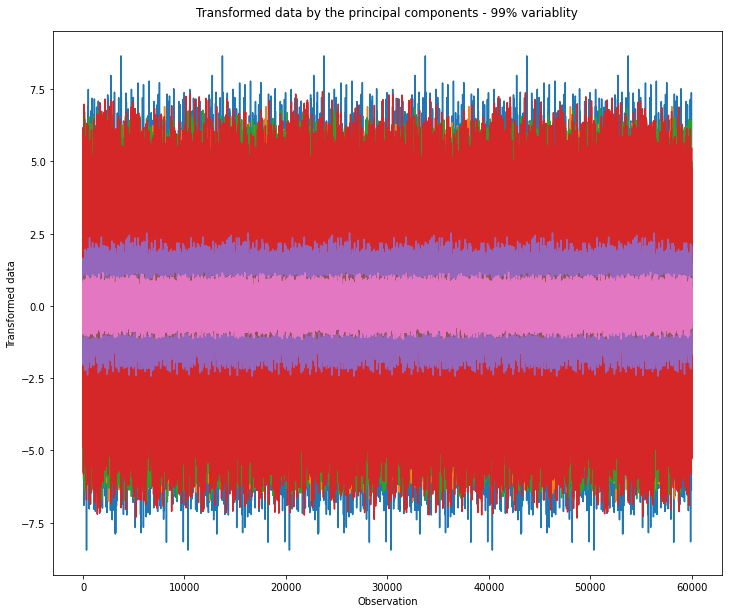

In [66]:
pca_99=PCA(n_components=0.99, random_state=2000)
pca_99.fit(X_red)
X_pca_99=pca_99.transform(X_red)
plt.figure(figsize=(12,10))
plt.plot(X_pca_99)
plt.title('Transformed data by the principal components - 99% variablity',pad=15)
plt.xlabel('Observation')
plt.ylabel('Transformed data')
print("{} compnents to preserve 99% of the variability in data".format(X_pca_99.shape))

In [67]:
scale = StandardScaler()
X_scaled_99 = scale.fit_transform(X_pca_99)
X_train_99,X_test_99,y_train_99,y_test_99=train_test_split(X_scaled_99,y,test_size=0.3)

In [68]:
number_of_features=7
network = Sequential()
network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
network.add(layers.Dense(units=6, activation="relu"))
network.add(layers.Dense(units=1, activation="sigmoid"))
network.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history=network.fit(X_train_99, y_train_99,callbacks=callbacks,validation_data = (X_test_99,y_test_99), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 1s 2ms/step - loss: 0.5951 - accuracy: 0.6732 - val_loss: 0.5148 - val_accuracy: 0.7456
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 0.5105 - accuracy: 0.7486 - val_loss: 0.4929 - val_accuracy: 0.7601
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4919 - accuracy: 0.7611 - val_loss: 0.4788 - val_accuracy: 0.7710
Epoch 4/100
420/420 [==============================] - 1s 1ms/step - loss: 0.4808 - accuracy: 0.7699 - val_loss: 0.4696 - val_accuracy: 0.7773
Epoch 5/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4731 - accuracy: 0.7745 - val_loss: 0.4635 - val_accuracy: 0.7813
Epoch 6/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4684 - accuracy: 0.7769 - val_loss: 0.4618 - val_accuracy: 0.7796
Epoch 7/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4657 - accuracy: 0.7783 - val_loss: 0.4583 - val_accuracy: 0.7827

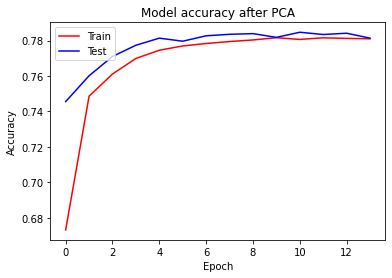

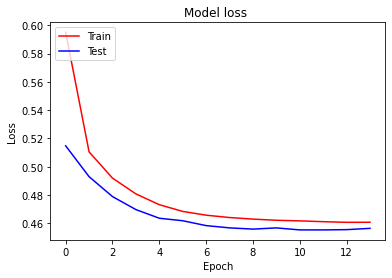

In [69]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy after PCA')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss ') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.70      0.67      0.68      6387
           1       0.82      0.84      0.83     11613

    accuracy                           0.78     18000
   macro avg       0.76      0.76      0.76     18000
weighted avg       0.78      0.78      0.78     18000



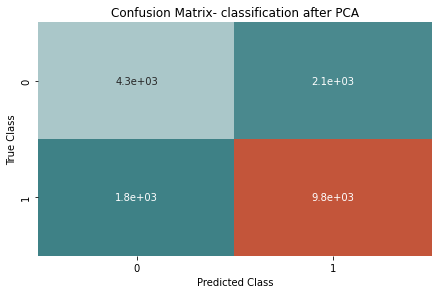

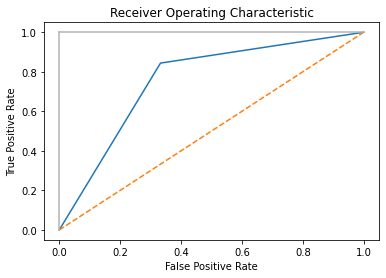

563/563 - 1s - loss: 0.4564 - accuracy: 0.7813 - 670ms/epoch - 1ms/step
Loss:  0.45636507868766785
Accuracy:  0.781333327293396


In [70]:
y_pred_99 = network.predict(X_test_99)
y_pred_99=(y_pred_99 > 0.5)
print("\nClassification report:\n")
target_names = ['0', '1']
class_names=[0,1]
print(classification_report(y_test_99, y_pred_99, target_names=target_names))
matrix = confusion_matrix(y_test_99, y_pred_99)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix- classification after PCA"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_99,
 y_pred_99)
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()
pca_loss, pca_acc = network.evaluate(X_test_99,  y_test_99, verbose=2)
print("Loss: ", pca_loss)
print("Accuracy: ", pca_acc)

<h1> Zaključak </h1>

Nakon PCA, rezultati klasifikacije su znatno lošiji. Redukcija dimenzionlanosti nije poboljšala rezultate, ali se neuronske mreže mogu koristiti za smanjenje dimenzionalnosti, kod drugih problema. Koriste se auto-enkoderi.
Auto-enkoder je vrsta nenadgledane neuronske mreže koja se koristi za smanjenje dimenzionalnosti i otkrivanje karakteristika. Tačnije, auto-enkoder je neuronska mreža koja je obučena da predviđa sam ulaz.


Kreirana neuronska mreža je u nekim slučajevima dala jako dobre rezultate. Rezultati su bili lošiji onda kada su korišćene tehnike smanjivanja overfittinga.
Neuronska mreža je jako dobro obučena i dala je dobre rezultate onda kada je kreirana custom loss funkcija, koja je prilagođena problemu.
